In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
df = pd.read_parquet('df.sample.parquet.gzip')
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id
6733995,2019-10-06 08:34:28+00:00,view,16700605,2053013559901684381,furniture.kitchen.chair,zeta,16.190001,518195082
4880941,2019-10-10 08:31:52+00:00,view,4800725,2053013554658804075,electronics.audio.headphone,sony,8.210000,512421337
6895456,2019-10-26 08:07:34+00:00,view,8800489,2053013555573162395,electronics.telephone,hiper,12.100000,518901124
807139,2019-10-07 06:33:45+00:00,cart,4201420,2053013552351936731,appliances.environment.air_conditioner,lg,787.630005,520085572
6297826,2019-10-25 18:07:49+00:00,view,1004739,2053013555631882655,electronics.smartphone,xiaomi,189.970001,513345774


In [3]:
df.shape

(1000000, 8)

In [4]:
df = df.drop('category_id', axis=1)
df.shape

(1000000, 7)

<Axes: xlabel='price'>

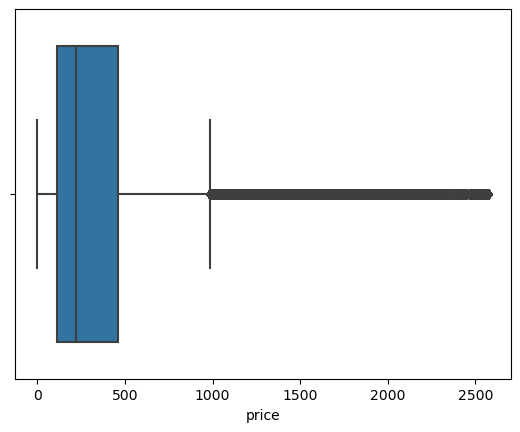

In [5]:
sns.boxplot(data=df, x='price')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 6733995 to 3615460
Data columns (total 7 columns):
 #   Column         Non-Null Count    Dtype              
---  ------         --------------    -----              
 0   event_time     1000000 non-null  datetime64[ns, UTC]
 1   event_type     1000000 non-null  category           
 2   product_id     1000000 non-null  int64              
 3   category_code  1000000 non-null  object             
 4   brand          1000000 non-null  object             
 5   price          1000000 non-null  float32            
 6   user_id        1000000 non-null  int64              
dtypes: category(1), datetime64[ns, UTC](1), float32(1), int64(2), object(2)
memory usage: 50.5+ MB


In [7]:
df['price'].describe()

count    1000000.000000
mean         352.464996
std          380.233673
min            0.000000
25%          109.080002
50%          218.490005
75%          459.070007
max         2574.070068
Name: price, dtype: float64

In [8]:
df[df['price'] <= 0]['event_type'].unique()

['view', 'cart']
Categories (3, object): ['cart', 'purchase', 'view']

In [9]:
df[df['user_id'] == 244951053]

,event_time,event_type,product_id,category_code,brand,price,user_id
2489108,2019-10-03 03:06:18+00:00,view,1005105,electronics.smartphone,apple,1415.47998,244951053


In [10]:
df = df[df['event_type'] == 'purchase']
df.shape

(20576, 7)

## RFM 계산

### 전체 주문에서 최근 주문일 구하기

In [11]:
last_timestamp = df['event_time'].max() + dt.timedelta(days=1)
last_timestamp

Timestamp('2019-11-01 23:49:19+0000', tz='UTC')

### 고객별 Recency, Frequency, Monetary 값 구하기

In [12]:
rfm = df.groupby('user_id').agg({'event_time' : lambda x: (last_timestamp - x.max()).days,
                                'product_id' : 'count',
                                'price' : 'sum'})
rfm

,event_time,product_id,price
user_id,,,
435648894,26,1,388.130005
437371552,30,1,179.139999
450756413,29,1,43.730000
456810531,7,1,133.350006
473668240,23,1,149.039993
...,...,...,...
566188229,1,1,221.339996
566210490,1,1,514.780029
566227458,1,1,465.910004


In [13]:
rfm.columns = ['Recency', 'Frequency', 'MonetaryValue']
rfm

,Recency,Frequency,MonetaryValue
user_id,,,
435648894,26,1,388.130005
437371552,30,1,179.139999
450756413,29,1,43.730000
456810531,7,1,133.350006
473668240,23,1,149.039993
...,...,...,...
566188229,1,1,221.339996
566210490,1,1,514.780029
566227458,1,1,465.910004


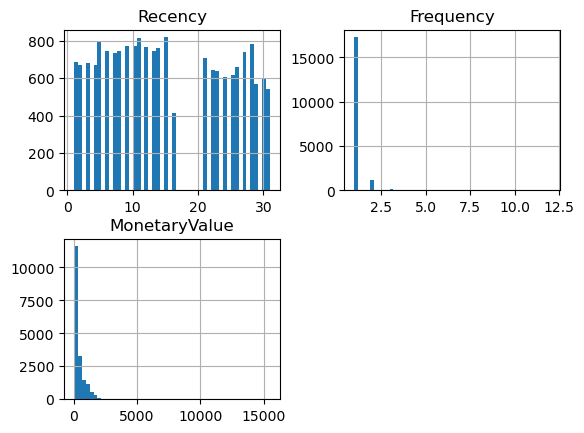

In [14]:
rfm.hist(bins=50);

### Scoring 기법
- R은 값이 낮을 수록 최근에 구매한 고객이기 때문에 높은 점수를 줄 예정입니다.
- F, M은 값이 높을 수록 높은 점수를 부여

In [15]:
list(range(5,0,-1))

[5, 4, 3, 2, 1]

In [16]:
cut_size=5
r_cut = pd.qcut(rfm['Recency'].rank(method='first'), cut_size, labels=list(range(5,0,-1)))
f_cut = pd.qcut(rfm['Frequency'].rank(method='first'), cut_size, labels=list(range(1,6)))
m_cut = pd.qcut(rfm['MonetaryValue'].rank(method='first'), cut_size, labels=list(range(1,6)))

In [17]:
rfm['R'] = r_cut
rfm['F'] = f_cut
rfm['M'] = m_cut
rfm

,Recency,Frequency,MonetaryValue,R,F,M
user_id,,,,,,
435648894,26,1,388.130005,2,1,4
437371552,30,1,179.139999,1,1,2
450756413,29,1,43.730000,1,1,1
456810531,7,1,133.350006,4,1,2
473668240,23,1,149.039993,2,1,2
...,...,...,...,...,...,...
566188229,1,1,221.339996,5,5,3
566210490,1,1,514.780029,5,5,4
566227458,1,1,465.910004,5,5,4


In [18]:
rfm[(rfm['Recency'] == 26) & (rfm['Frequency'] == 1)]

,Recency,Frequency,MonetaryValue,R,F,M
user_id,,,,,,
435648894,26,1,388.130005,2,1,4
512364788,26,1,161.830002,2,1,2
512365112,26,1,286.600006,2,1,3
512367876,26,1,69.419998,2,1,1
512381373,26,1,187.649994,2,1,3
...,...,...,...,...,...,...
557482220,26,1,424.459991,1,4,4
557490199,26,1,173.929993,1,4,2
557507984,26,1,230.589996,1,4,3


### RFM Segment

In [19]:
rfm["RFM_segment"] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)
rfm

,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment
user_id,,,,,,,
435648894,26,1,388.130005,2,1,4,214
437371552,30,1,179.139999,1,1,2,112
450756413,29,1,43.730000,1,1,1,111
456810531,7,1,133.350006,4,1,2,412
473668240,23,1,149.039993,2,1,2,212
...,...,...,...,...,...,...,...
566188229,1,1,221.339996,5,5,3,553
566210490,1,1,514.780029,5,5,4,554
566227458,1,1,465.910004,5,5,4,554


In [20]:
rfm["RFM_segment"].value_counts()

555    374
142    281
454    263
455    260
242    258
      ... 
252     29
153     22
251     16
151     10
152      5
Name: RFM_segment, Length: 125, dtype: int64

### RFM Score

In [21]:
rfm["RFM_score"] = rfm[['R', 'F', 'M']].sum(axis=1)
rfm.head(2)

,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score
user_id,,,,,,,,
435648894,26,1,388.130005,2,1,4,214,7
437371552,30,1,179.139999,1,1,2,112,4


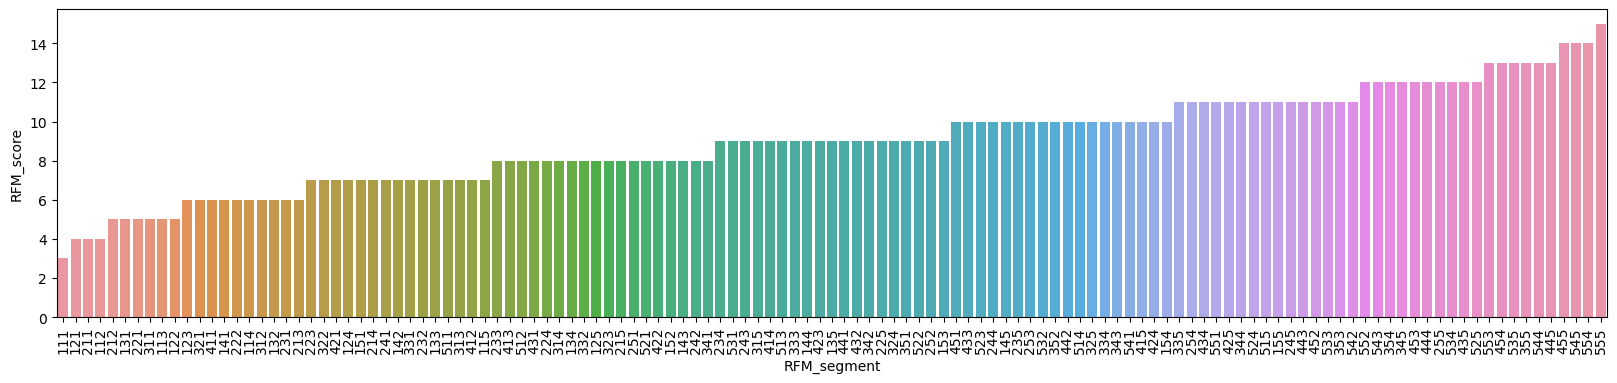

In [22]:
# RFM segment 값에 따라 정렬합니다.
plt.figure(figsize=(20, 4))
plt.xticks(rotation=90)
sns.barplot(data=rfm.sort_values('RFM_score'), x='RFM_segment', y='RFM_score');

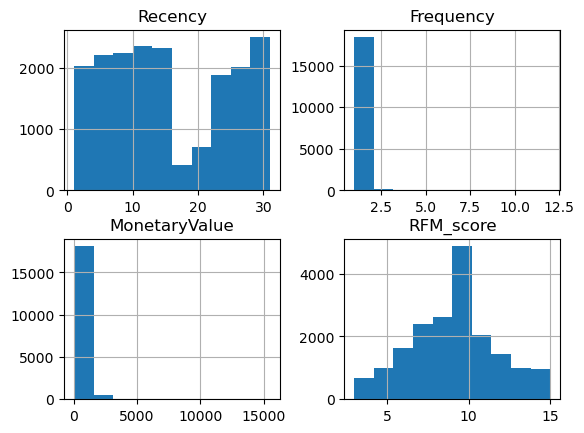

In [23]:
rfm.hist();

In [24]:
rfm.iloc[:,:-2]

,Recency,Frequency,MonetaryValue,R,F,M
user_id,,,,,,
435648894,26,1,388.130005,2,1,4
437371552,30,1,179.139999,1,1,2
450756413,29,1,43.730000,1,1,1
456810531,7,1,133.350006,4,1,2
473668240,23,1,149.039993,2,1,2
...,...,...,...,...,...,...
566188229,1,1,221.339996,5,5,3
566210490,1,1,514.780029,5,5,4
566227458,1,1,465.910004,5,5,4


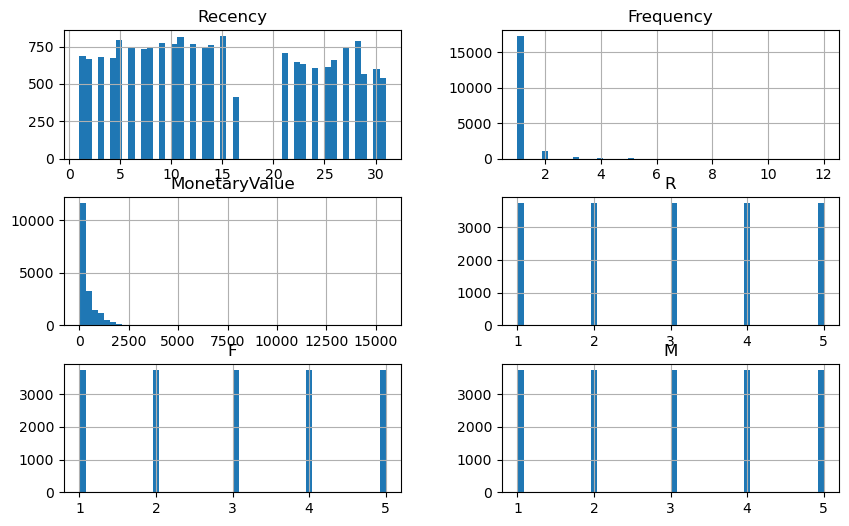

In [25]:
rfm.iloc[:,:-2].astype(float).hist(figsize=(10,6), bins=50);

In [26]:
rfm_score = rfm.groupby('RFM_score').agg({'Recency':'mean',
                                         'Frequency':'mean',
                                         'MonetaryValue':['mean', 'sum']})
rfm_score.style.background_gradient().format('{:,.0f}')

### qcut을 통한 고객군 나누기

In [27]:
rfm.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score
user_id,,,,,,,,
435648894,26,1,388.130005,2,1,4,214,7
437371552,30,1,179.139999,1,1,2,112,4
450756413,29,1,43.730000,1,1,1,111,3
456810531,7,1,133.350006,4,1,2,412,7
473668240,23,1,149.039993,2,1,2,212,5


In [28]:
# qcut을 RFM_score에 따라 3단계 "silver", "gold", "platinum"로 고객군을 나눕니다.
cut_size = 3
labels = ['silver', 'gold', 'platinum']
rfm['RFM_class'] = pd.qcut(rfm['RFM_score'], cut_size, labels=labels)
rfm

,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score,RFM_class
user_id,,,,,,,,,
435648894,26,1,388.130005,2,1,4,214,7,silver
437371552,30,1,179.139999,1,1,2,112,4,silver
450756413,29,1,43.730000,1,1,1,111,3,silver
456810531,7,1,133.350006,4,1,2,412,7,silver
473668240,23,1,149.039993,2,1,2,212,5,silver
...,...,...,...,...,...,...,...,...,...
566188229,1,1,221.339996,5,5,3,553,13,platinum
566210490,1,1,514.780029,5,5,4,554,14,platinum
566227458,1,1,465.910004,5,5,4,554,14,platinum


In [29]:
pd.set_option('display.max_rows', None)
rfm[rfm['Frequency'] == 1].sort_values(['Recency', 'MonetaryValue'], ascending=[True, False])['RFM_class'].head(3000)

user_id
548485481    platinum
558770536    platinum
565974848    platinum
512721548    platinum
526113408    platinum
515294461    platinum
524843982    platinum
566088545    platinum
526755962    platinum
563678048    platinum
527710058    platinum
566246516    platinum
520064893    platinum
540528598    platinum
516001410    platinum
561404068    platinum
512371970    platinum
516455994    platinum
522829010    platinum
514566956    platinum
565883988    platinum
513455801    platinum
540306118    platinum
560977650    platinum
548469341    platinum
516011075    platinum
516123862    platinum
521951388    platinum
537264300    platinum
513639720    platinum
547428245    platinum
513886874    platinum
513941722    platinum
537232559    platinum
550208269    platinum
553381618    platinum
557330353    platinum
512678758    platinum
513849031    platinum
516364076    platinum
548916848    platinum
536158292    platinum
514124563    platinum
536018957    platinum
516794195    platinum
52

In [30]:
rfm.groupby('RFM_class')['RFM_score'].describe()

,count,mean,std,min,25%,50%,75%,max
RFM_class,,,,,,,,
silver,8366.0,6.608535,1.308346,3.0,6.0,7.0,8.0,8.0
gold,4870.0,9.486448,0.499868,9.0,9.0,9.0,10.0,10.0
platinum,5448.0,12.237518,1.248803,11.0,11.0,12.0,13.0,15.0


In [31]:
rfm.groupby('RFM_class').agg({'Recency':'mean', 'Frequency':'mean',
                             'MonetaryValue':['mean', 'sum', 'count']})

Recency Frequency MonetaryValue                   
                mean      mean          mean          sum count
RFM_class                                                      
silver     20.515300  1.003586    218.376770  1826940.000  8366
gold       13.768994  1.025462    414.418610  2018218.625  4870
platinum    7.986784  1.319016    697.116882  3797892.750  5448

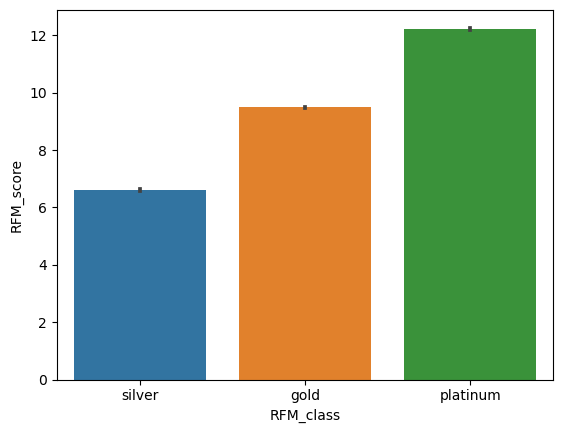

In [32]:
sns.barplot(data=rfm, x="RFM_class", y="RFM_score");

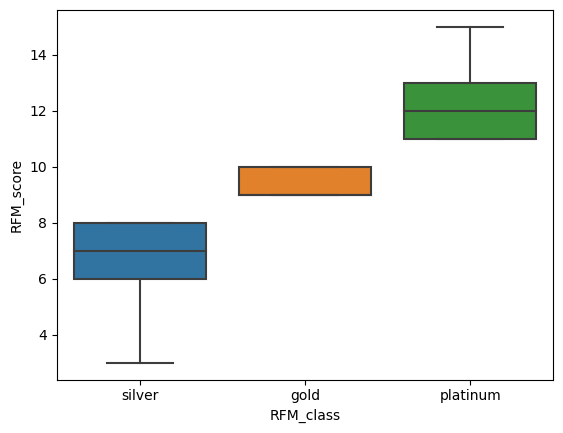

In [33]:
sns.boxplot(data=rfm, x="RFM_class", y="RFM_score");

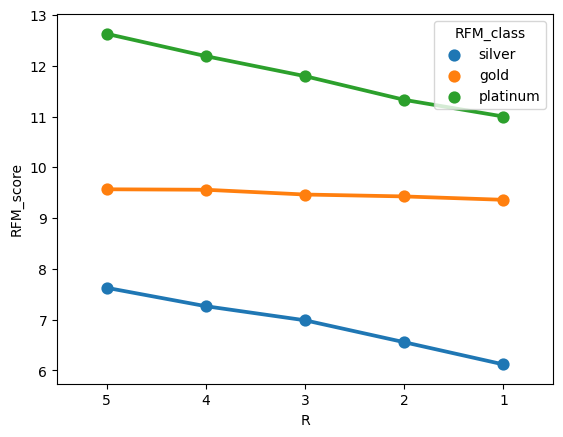

In [34]:
sns.pointplot(data=rfm, x='R', y='RFM_score', hue='RFM_class');

In [35]:
file_path_parquet = 'rfm.parquet.gzip'
rfm.to_parquet(file_path_parquet, compression='gzip')

In [36]:
pd.read_parquet(file_path_parquet).head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score,RFM_class
user_id,,,,,,,,,
435648894,26,1,388.130005,2,1,4,214,7,silver
437371552,30,1,179.139999,1,1,2,112,4,silver
450756413,29,1,43.730000,1,1,1,111,3,silver
456810531,7,1,133.350006,4,1,2,412,7,silver
473668240,23,1,149.039993,2,1,2,212,5,silver


In [37]:
pd.read_parquet(file_path_parquet).tail()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score,RFM_class
user_id,,,,,,,,,
566188229,1,1,221.339996,5,5,3,553,13,platinum
566210490,1,1,514.780029,5,5,4,554,14,platinum
566227458,1,1,465.910004,5,5,4,554,14,platinum
566246516,1,1,1661.089966,5,5,5,555,15,platinum
566258164,1,1,720.479980,5,5,5,555,15,platinum
